# Neural Tangent Kernel

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt

Today we study attempt to compare the behavior of neural nets and their NTK on some simple example.



# The data


To do so we are going to use the FashionMNIST dataset to build a small binary classification task, train some neural nets on those tasks, and build the corresponding NTK. 

In [4]:
n = 200 # number of training points that we keep
c1, c2 = 3, 6 # subclasses that are kept, make sure that c1 < c2

batch_size = 32 # training batch size

classes = ("T-shirt/Top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat", 
        "Sandal", 
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle Boot"
)

# Define a sequence of operations that will be performed to all training images before use
# the 'ToTensor()' function sets the image in tensor object and puts the values of every pixel between 0 and 1
# the 'Normalize' performs the dataset to a given mean and variance
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])

# Creates an object to load the images. We use FashionMNIST as a substitute for MNIST because binary classification on 
# subclasses of MNIST is too easy. 

trainset = datasets.FashionMNIST('../data', train=True, download=True, transform=transform)

r = torch.arange(len(trainset))

# Build a training set that only contains images with classes c1 and c2, with n / 2 images from each label. 

idxc1 = (torch.as_tensor(trainset.targets) == c1)
x1 = np.where(np.cumsum(idxc1) == (n / 2))[0][0]
idxc1 = idxc1 & (r <= x1)

idxc2 = (torch.as_tensor(trainset.targets) == c2) 
x2 = np.where(np.cumsum(idxc2) == (n / 2))[0][0]
idxc2 = (torch.as_tensor(trainset.targets) == c2) & (r <= x2)

idx = idxc1 + idxc2
dset_train = torch.utils.data.dataset.Subset(trainset, np.where(idx==1)[0])

print(f'Number of training points : {len(dset_train)}')
trainloader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size)

# Build the corresponding test set

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
idx = torch.as_tensor(testset.targets) == c1
idx += torch.as_tensor(testset.targets) == c2
dset_test = torch.utils.data.dataset.Subset(testset, np.where(idx==1)[0])
testloader = torch.utils.data.DataLoader(dset_test)

Number of training points : 200


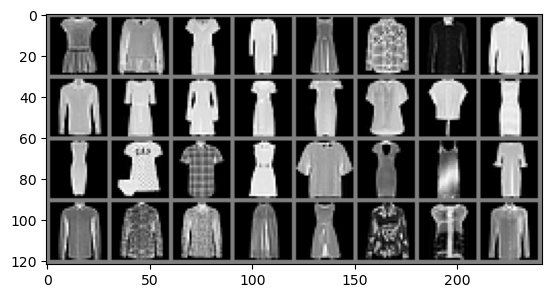

Dress Shirt Dress Dress Dress Shirt Shirt Shirt Shirt Dress Dress Dress Dress Shirt Shirt Dress Dress Dress Shirt Dress Shirt Dress Dress Dress Shirt Shirt Shirt Shirt Dress Shirt Shirt Shirt


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get batch_size random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# A neural network

Fully connected 1-hidden layer neural network. Flattens the image and treats it as a vector. 

Use the methods

`nn.Flatten`
`nn.Linear`

`nn.init.xavier_normal_`
`nn.init.zeros_`

to build the network

In [61]:
class MLPshallow(nn.Module): 
    def __init__(self, hidden_dim=10):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.flattener=nn.Flatten()
        self.lin=nn.Linear(28*28,self.hidden_dim,bias=False)
        self.lout=nn.Linear(self.hidden_dim,1,bias=False)

        nn.init.kaiming_normal_(self.lin.weight)
        nn.init.kaiming_normal_(self.lout.weight)

    def forward(self, x):
        x=self.flattener(x)
        x=self.lin(x)
        x=F.relu(x)
        x=self.lout(x)
        return x

net = MLPshallow(hidden_dim=30)

## The training function

We train the network with the square loss to predict the class. The labels are normalized to be between $0$ and $1$.

i.e. the y-value for images with label `i`  is `float(i/9)`

Write the training function. 

In [62]:
def train(net, 
          trainloader, 
          N_passes=1, 
          lr=0.01):
    
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []
    i = 0

    for _ in range(N_passes):
        for inputs, labels in trainloader: 
            i += 1
            optimizer.zero_grad()

            outputs=net(inputs)
            
            target=labels.float().unsqueeze(1)/9 # tensor of shape batch size, transformed to have float value adn shape (batch size,1)
            loss=criterion(outputs,target)
            
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().numpy())

    print(f'Number of gradient steps {i}')

    return losses

Batch size :  32
Number of gradient steps 2100


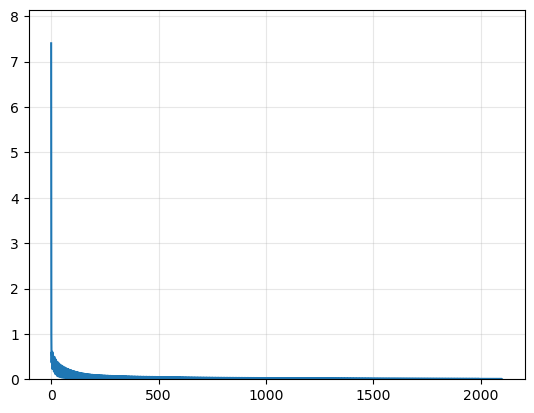

In [63]:
print('Batch size : ', batch_size)

losses = train(net, 
    trainloader,
    N_passes=300,  
    lr=0.001)

plt.ylim(0, 1.1 * np.max(losses))
plt.plot(losses)
plt.grid(alpha=.3)

### Checking the training values

Complete the following function to get the prediction of the network on the data. 

Train the network until you interpolate the data.

In [64]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in trainloader:
        outputs = net(images)
        predicted = c1+ (c2-c1)*(9*outputs> (c1 +c2)/2)

        total += labels.size(0)
        correct += (predicted.squeeze(1) == labels).sum()

print(f'Accuracy of the network on the {total} train images: {100 * correct // total} %')

Accuracy of the network on the 200 train images: 95 %


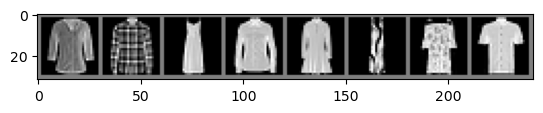

GrndTruth:  Shirt Shirt Dress Shirt Dress Dress Dress Shirt
Predicted:  Shirt Shirt Dress Dress Dress Dress Shirt Shirt


In [65]:
testloader = torch.utils.data.DataLoader(dset_test, batch_size=8)
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:8]))
print('GrndTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

with torch.no_grad():
    outputs = net(images)
    predicted = c1+ (c2-c1)*(9*outputs> (c1 +c2)/2)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))

# Test loss

In [66]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        predicted = c1+ (c2-c1)*(9*outputs> (c1 +c2)/2)

        total += labels.size(0)
        correct += (predicted.squeeze(1) == labels).sum()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 2000 test images: 68 %


# The NTK

Let us write the corresponding NTK in the infinite width limit. Use the formula seen in class for the NTK kernel to complete the code below.

In [67]:
class NTK:
    def __init__(self, dset_train):
        self.n = len(dset_train)
        self.train_set = dset_train
        self.train()
        
    def k(self, x, xprime):
        '''
            NTK Kernel for ReLU with one hidden layer. The delta factor is to avoid some annoying rounding for arrccos. 
        '''
        delta = .999999
        with torch.no_grad():
            v = torch.linalg.norm(x) * torch.linalg.norm(xprime)
            u = delta * torch.dot(x, xprime) / v
            return (2*v *(np.pi-torch.acos(u)) +np.sqrt(1-u**2))/np.pi

    def train(self):
        ntrainloader = torch.utils.data.DataLoader(self.train_set, batch_size=self.n)
        dataiter = iter(ntrainloader)
        images, labels = next(dataiter)
        print(images.flatten(start_dim=1, end_dim=3).shape)

        xis = images.flatten(start_dim=1, end_dim=3)
        print(xis.shape)

        self.xis = xis

        # plt.imshow(xis)
        # plt.title('Flattened images')
        # plt.show()

        H = torch.empty((n, n))

        for i in range(n):
            for j in range(n):
                H[i, j] = self.k(xis[i], xis[j])

        plt.title(f'Gram matrix for {n} x {n} inputs')
        plt.imshow(H)
        plt.colorbar()
        plt.show()

        eigenvalues = np.linalg.eigvalsh(H)
        print(f'Smallest eigenvalue : {eigenvalues[0]}')
        # plt.title('Sorted eigenvalues of the Gram matrix')
        # plt.plot(eigenvalues)
        # plt.grid(alpha=0.3)
        # plt.ylim(0, 1.01 * np.max(eigenvalues))
        # plt.show()

        self.H = H
        self.Hinv = torch.linalg.inv(H)
        self.V =  self.Hinv @ labels.float() / 9

        print(self.V.shape)

        # plt.imshow(V)
        # plt.colorbar()
        # plt.show()

    def apply(self, x):
        s = 0
        for i, xi in enumerate(self.xis):
            s += self.k(x, xi) * self.V[i] 
        return s

torch.Size([200, 784])
torch.Size([200, 784])


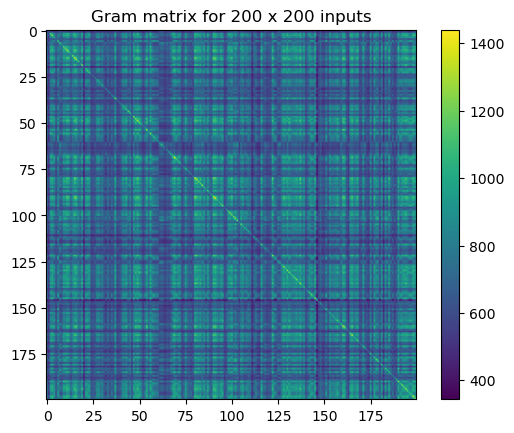

Smallest eigenvalue : 55.74605941772461
torch.Size([200])


In [68]:
ntk = NTK(dset_train)

In [69]:
ntk_trainloader = torch.utils.data.DataLoader(dset_train, batch_size=1)

correct_ntk = 0
total = 0
with torch.no_grad():
    for images, labels in ntk_trainloader:
        x = torch.flatten(images.squeeze(0)) 
    
        output_ntk = ntk.apply(x)
        predicted_ntk = c1 + (c2 - c1) * (9 * output_ntk > (c1 + c2) / 2) # c1 if prediction is less than average, 
        correct_ntk += (predicted_ntk.unsqueeze(0) == labels).numpy()[0]

        total += 1

print(f'Accuracy of NTK on the {total} train images: {100 * correct_ntk // total} %')


Accuracy of NTK on the 200 train images: 100 %


Let us now compare the outputs of the NTK and of the network. 

What do you observe? Why?

In [70]:
testloader = torch.utils.data.DataLoader(dset_test)

total = 0
correct_ntk = 0
correct_net = 0
agree = 0 

with torch.no_grad():
    for images, labels in testloader:
        x = torch.flatten(images.squeeze(0)) 
    
        output_ntk = ntk.apply(x)
        predicted_ntk = c1 + (c2 - c1) * (9 * output_ntk > (c1 + c2) / 2) # c1 if prediction is less than average, 
        correct_ntk += (predicted_ntk.unsqueeze(0) == labels).numpy()[0]

        outputs = net(images)
        predicted = c1 + (c2 - c1) * (9 * outputs > (c1 + c2) / 2) # c1 if prediction is less than average, 
        correct_net += (predicted.squeeze(1) == labels).numpy()[0]

        # print(labels.shape)
        # print(predicted_ntk.unsqueeze(0).shape, predicted_ntk.unsqueeze(0))
        # print(predicted.squeeze(1).shape, predicted.squeeze(1))

        agree += (predicted_ntk.unsqueeze(0) == predicted.squeeze(1)).numpy()[0]
        total += 1

print(f'Accuracy of NTK on the {total} test images: {100 * correct_ntk // total} %')
print(f'Accuracy of net on the {total} test images: {100 * correct_net // total} %')

print(f'Both methods agree on {100 * agree // total} % of the images')

Accuracy of NTK on the 2000 test images: 91 %
Accuracy of net on the 2000 test images: 68 %
Both methods agree on 69 % of the images


# The NTK Gram matrix is typically invertible 

if number of data points is smaller than input dim

We plot a ReLU NTK matrix for random data and check that the eigenvalues are typically ok. 

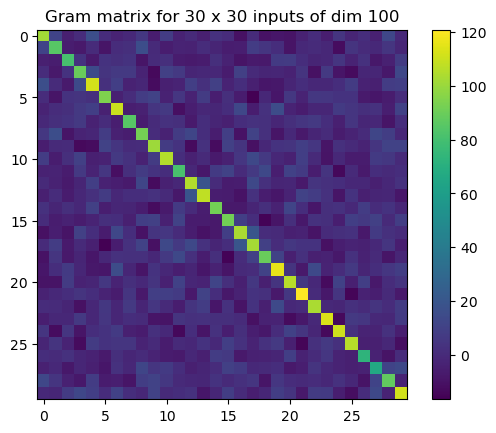

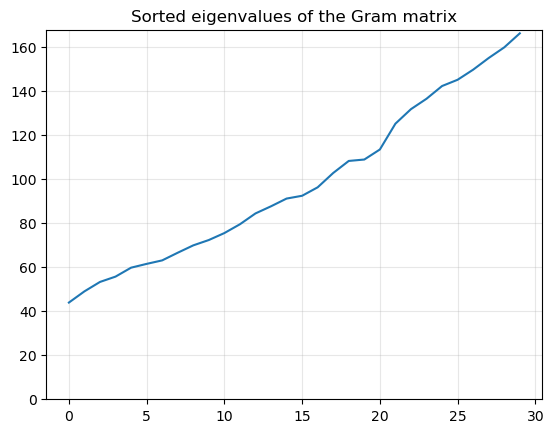

In [71]:
n = 30
d = 100

xis = [torch.randn(d) for _ in range(n)]

H = torch.empty((n, n))

def k(x, xprime):
    with torch.no_grad():
        v = torch.linalg.norm(x) * torch.linalg.norm(xprime)
        u = .99999 * torch.dot(x, xprime) / v
        return v * (u * (torch.pi - torch.arccos(u) + torch.sqrt(1 - u ** 2) )/ (2 * np.pi)
                    +  u * (torch.pi - torch.arccos(u)) /  (2 * np.pi))

for i in range(n):
    for j in range(n):
        H[i,j] = k(xis[i], xis[j])


plt.title(f'Gram matrix for {n} x {n} inputs of dim {d}')
plt.imshow(H)
plt.colorbar()

plt.show()

plt.title('Sorted eigenvalues of the Gram matrix')
eigvals = np.linalg.eigvalsh(H)
plt.plot(eigvals)
plt.grid(alpha=0.3)
plt.ylim(0, 1.01 * np.max(eigvals))
plt.show()


In [72]:
# mlp = MLPdeep() # MLPshallow()
# PATH = f'./{dataset.type}_{mlp.net_type}.pth'
# torch.save(mlp.state_dict(), PATH)

# net = MLPdeep() # MLPshallow()
# net.load_state_dict(torch.load(PATH))

#  Overparameterized linear regression

Largest eigenvalue of of XX^\top : 17.301400196338346


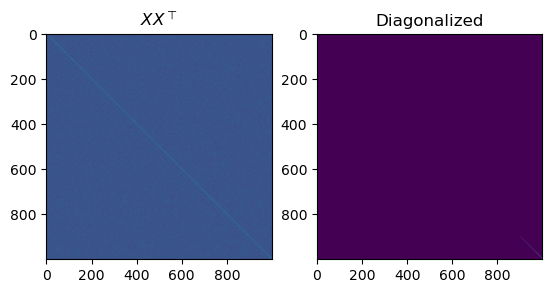

100


In [73]:
p = 1000
n = 100

X = np.random.normal(size=(p, n))  / np.sqrt(n) 
Y = np.random.normal(size=(n, 1))

XXt = X @ X.transpose()
XY = X @ Y

fig, axs = plt.subplots(1, 2)

axs[0].set_title(r'$X X^\top $')
axs[0].imshow(XXt)

eigvals, P = np.linalg.eigh(XXt)
print(rf'Largest eigenvalue of of XX^\top : {max(eigvals)}')

axs[1].set_title('Diagonalized')
axs[1].imshow(P.transpose() @ XXt @ P)
plt.show()

print(np.linalg.matrix_rank(X))

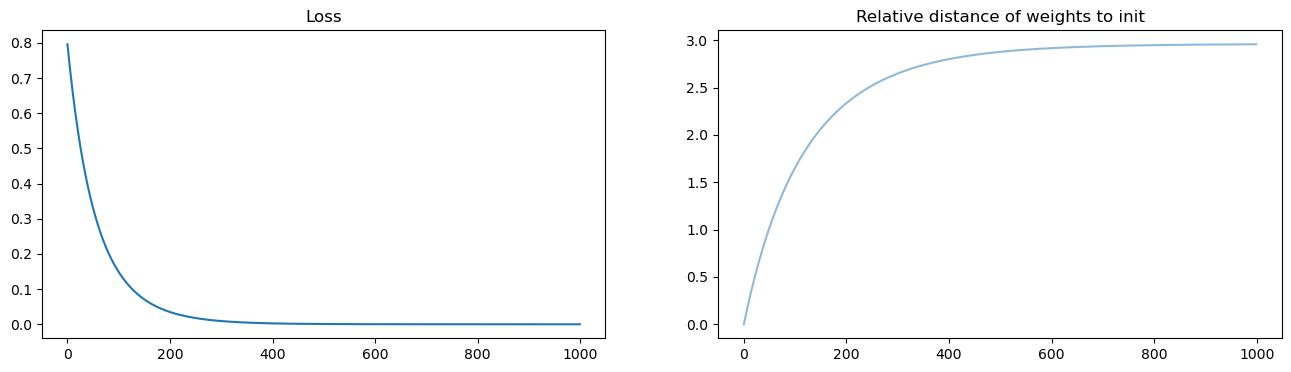

In [74]:
T = 1000
eta = 0.001

ws = np.zeros((T, p, 1))
w = np.random.normal(size=(p, 1))  / np.sqrt(p)

losses = []
for t in range(T):
    w = w - eta * XXt @ w + eta * XY
    ws[t] = w

    losses.append(np.linalg.norm(X.transpose() @ w  - Y)**2 / n )

ws = ws.squeeze(axis=2)
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].set_title('Loss')
axs[0].plot(losses) 


axs[1].set_title('Relative distance of weights to init')
weight_evol = np.linalg.norm(ws - ws[0, :], axis=1) / np.linalg.norm(ws[0, :])
axs[1].plot(weight_evol, alpha=.5) 
 

plt.show()

#### In the right basis, most coordinates of w dont move

w only moves in a low dimensional subspace: the image of X

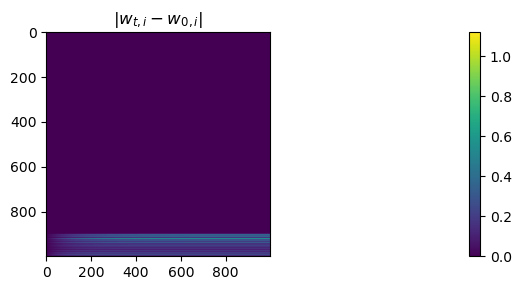

In [75]:
fig, ax = plt.subplots(figsize=(40, 3))

plt.title(r'$|w_{t, i} - w_{0, i}|$')
ws_in_base = ws @ P

a = ax.imshow(np.abs((ws_in_base - ws_in_base[0]).transpose()))
fig.colorbar(a)
plt.tight_layout()
plt.show()